In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import bert
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

embedding_dim = 200
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion= .1

corpus = []

In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
#    -O /tmp/training_cleaned.csv

# Your Code here. Create list items where the first item is the text, found in row[5], 
# and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
# your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences

num_sentences = 0

with open("./datasets/sentiment140/training_cleaned.csv", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [3]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [4]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [5]:
def tokenize_sequence(text_sequence):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_sequence))

In [7]:
import re

In [8]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

sequences = [re.sub(r'^https?:\/\/.*[\r\n]*', '', sequence, flags=re.MULTILINE) for sequence in sentences]
sequences = [tokenize_sequence(sequence) for sequence in sentences]

In [9]:
max_len = 0
for i in sequences:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in sequences])

In [10]:
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [11]:
attention_mask = np.where(padded != 0, 1, 0)

In [12]:
vocab_size = len(tokenizer.vocab)
print(vocab_size)

30522


In [13]:
'''model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, trainable=False),
    tf.keras.layers.Conv1D(256, 5, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(x=np.array(training_sequences), y=np.array(training_labels), epochs=num_epochs, validation_data=(np.array(test_sequences),np.array(test_labels)), batch_size = 1024, verbose=2)

print("Training Complete")
'''

'model = tf.keras.Sequential([\n    tf.keras.layers.Embedding(vocab_size, embedding_dim, trainable=False),\n    tf.keras.layers.Conv1D(256, 5, activation=\'relu\'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Conv1D(64, 5, activation=\'relu\'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.MaxPooling1D(pool_size=4),\n    tf.keras.layers.LSTM(64),\n    tf.keras.layers.Dense(1, activation=\'sigmoid\')\n])\n\n\nmodel.compile(loss=\'binary_crossentropy\',optimizer=\'adam\',metrics=[\'accuracy\'])\nmodel.summary()\n\nnum_epochs = 50\nhistory = model.fit(x=np.array(training_sequences), y=np.array(training_labels), epochs=num_epochs, validation_data=(np.array(test_sequences),np.array(test_labels)), batch_size = 1024, verbose=2)\n\nprint("Training Complete")\n'

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128, 5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
model.summary()

num_epochs = 20
history = model.fit(x=np.array(training_sequences), y=np.array(training_labels), epochs=num_epochs, validation_data=(np.array(test_sequences),np.array(test_labels)),batch_size = 2048, verbose=2)

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         6104400   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         128128    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)        

<Figure size 432x288 with 0 Axes>

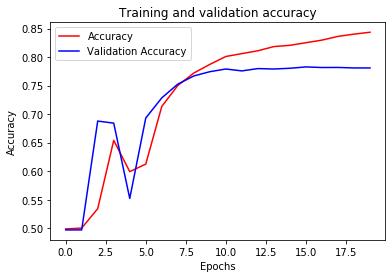

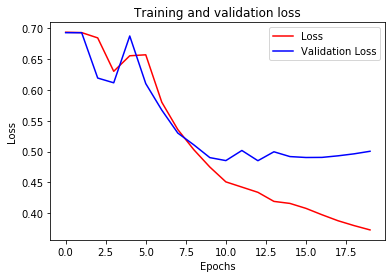

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!